Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

C:\Users\thoma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 92s 4s/step - loss: 2.7612 - accuracy: 0.1114 - val_loss: 2.2781 - val_accuracy: 0.1150
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 2.2364 - accuracy: 0.1765
Epoch 2: val_accuracy improved from 0.11500 to 0.27500, saving model to best_model.h5
25/25 [==============================] - 89s 4s/step - loss: 2.2364 - accuracy: 0.1765 - val_loss: 2.0688 - val_accuracy: 0.2750
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.9424 - accuracy: 0.2879
Epoch 3: val_accuracy improved from 0.27500 to 0.37500, saving model to best_model.h5
25/25 [==============================] - 90s 4s/step - loss: 1.9424 - accuracy: 0.2879 - val_loss: 1.7509 - val_accuracy: 0.3750
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 1.7809 - accuracy: 0.3617
Epoch 4: val_accuracy improved from 0.37500 to 0.44000, saving model to best_model.h5
25/25 [==============================] - 88s 4s/step - loss: 1.7809 - acc

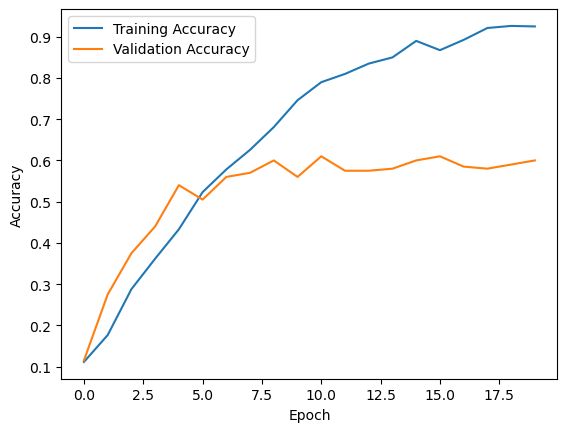

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import os

# Set the path to the directory containing the spectrogram images
spectrogram_dir = 'data/'

# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = load_img(img_path, target_size=(256, 256))  # Adjust target_size as needed
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_name)

    return np.array(images), np.array(labels)

# Load and preprocess the spectrogram images
X, y = load_images(spectrogram_dir)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)  # Use learning_rate instead of lr
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Set up model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical), callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
import librosa
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5')  # Replace with the actual path to your best_model file

# Load the external audio file
external_audio_path = 'genres_original/country/country.00037.wav'  # Replace with the actual path to your audio file
y, sr = librosa.load(external_audio_path)

# Convert the external audio to a spectrogram
spectrogram = np.abs(librosa.stft(y))
spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)  # Convert to dB scale
spectrogram = np.expand_dims(spectrogram, axis=-1)  # Add a channel dimension
spectrogram = np.expand_dims(spectrogram, axis=0)  # Add a batch dimension

# Define the target shape
target_shape = model.input_shape[1:-1]

# Resize the spectrogram using cv2.resize
dsize = (target_shape[1], target_shape[0])  # Ensure non-zero values and swap height and width
spectrogram_resized = cv2.resize(spectrogram[0, :, :, 0], dsize, interpolation=cv2.INTER_LINEAR)
spectrogram_resized = np.expand_dims(spectrogram_resized, axis=-1)  # Add the channel dimension back
spectrogram_resized = np.repeat(spectrogram_resized, 3, axis=-1)  # Repeat the single channel to create three identical channels

# Make predictions using the loaded model
predictions = model.predict(np.expand_dims(spectrogram_resized, axis=0))

# Assuming you have a list of class labels, you can get the predicted label
class_labels = ['Blue', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
predicted_label = class_labels[np.argmax(predictions)]

print(f"Predicted Label: {predicted_label}")


1/1 [==============================] - 0s 205ms/step
Predicted Label: Pop
